# Search Engine

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
def time_elapsed(s):
    '''
    Function to establish baselines for time needed to setup a search engine
    '''
    print("Time Elapsed: {} seconds".format(round(time.time() - s, 4)))

## Importing embedding nets

In [3]:
import pickle

In [4]:
s = time.time()
text_net = pickle.load(open("pickles/models/entire_nuswide_model.p", "rb"))
def get_text_embedding(*data):
    return text_net.text_embedding_net.to('cuda')(data[0])
text_net.get_embedding = get_text_embedding

image_net = pickle.load(open("pickles/models/entire_nuswide_model.p", "rb"))
time_elapsed(s)

Time Elapsed: 3.0384 seconds


## Importing datasets

`modality_data[i]` should return `(tensor, index)` of ith item

`modality_from_idx[i]` should return `value` of ith item

#### Image Dataset (NUS-WIDE)

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

In [6]:
s = time.time()

image_directory = 'data/Flickr'
image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

image_data = ImageFolder('data/Flickr', transform = image_transform)
image_from_idx = ImageFolder('data/Flickr', transform = None)

time_elapsed(s)

Time Elapsed: 2.1959 seconds


#### Text Dataset (word2vec)

In [7]:
s = time.time()

word2vec_dict = pickle.load(open("pickles/word_embeddings/word_embeddings_tensors.p", "rb"))

time_elapsed(s)

Time Elapsed: 66.8911 seconds


In [8]:
s = time.time()

text_from_idx = [None] * len(word2vec_dict)
text_data = [None] * len(word2vec_dict)
for idx, (key, value) in enumerate(word2vec_dict.items()):
    text_from_idx[idx] = key
    text_data[idx] = (value, idx)

time_elapsed(s)

Time Elapsed: 0.9564 seconds


## Creating Data Loaders

Need to enable batch processing of data for GPU acceleration

In [9]:
from torch.cuda import is_available

batch_size = 128
cuda = is_available()
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}

In [10]:
from torch.utils.data import DataLoader

image_dataloader = DataLoader(image_data, batch_size = batch_size, **kwargs)
text_dataloader = DataLoader(text_data, batch_size = batch_size, **kwargs)

## Setting up SearchEngines

In [11]:
from search import SearchEngine

In [12]:
embedding_dimension = 30 # embedding dimension of network being used 
save_directory = './binary_embeddings'

In [13]:
text_search_engine = SearchEngine(text_net, embedding_dimension,
    cuda = cuda,
    is_binarized = False,
    embeddings_name = "wiki_word2vec",
    save_directory = save_directory + '/text',
)

In [14]:
image_search_engine = SearchEngine(image_net, embedding_dimension,
    cuda = cuda,
    is_binarized = False,
    embeddings_name = "nuswide",
    save_directory = save_directory + '/image',
)

### Sanity Check

Want to check what the embeddings look like

In [15]:
import random

In [16]:
s = time.time()
image = image_from_idx[random.randint(0,len(image_from_idx))][0]
image_tensor = image_transform(image)[None,:,:,:]
embedding = image_search_engine.get_embedding(image_tensor)
print(embedding[0])
time_elapsed(s)

tensor([ 0.0429,  0.0144,  0.3263,  0.1666,  0.0565,  0.1448,  0.1314, -0.0891,
        -0.1919, -0.1369, -0.0251, -0.0530,  0.1053, -0.0115, -0.6209, -0.1625,
        -0.1266, -0.4883,  0.1914,  0.2240, -0.1033,  0.0727,  0.0947, -0.0673,
        -0.1294, -0.0559,  0.0129,  0.0115, -0.1883,  0.3113],
       device='cuda:0')
Time Elapsed: 0.0306 seconds


In [17]:
s = time.time()
text = 'cat'
text_tensor = word2vec_dict[text]
embedding = text_search_engine.get_embedding(text_tensor.unsqueeze(0))
print(embedding[0])
time_elapsed(s)

tensor([-0.0468, -0.0982, -0.4834, -0.3596,  0.2150, -0.3051, -0.3425, -0.5085,
         0.2837,  0.2414, -0.2529,  0.3140, -0.0941, -0.0898,  0.0838, -0.2856,
        -0.2671, -0.0076,  0.4191,  0.3694, -0.3189,  0.5203,  0.7848, -0.3624,
         0.3396, -0.2196,  0.0415,  0.2847,  0.4547,  0.1154],
       device='cuda:0')
Time Elapsed: 0.0017 seconds


## Indexing data in SearchEngines

In [18]:
# Processed images in ~900 seconds

image_search_engine.fit(
    data = image_dataloader, 
    verbose = True, 
    step_size=100, 
    load_embeddings=True)

Sanity checks passed.
Batch 0 of 2107
Batch 100 of 2107
Batch 200 of 2107
Batch 300 of 2107
Batch 400 of 2107
Batch 500 of 2107
Batch 600 of 2107
Batch 700 of 2107
Batch 800 of 2107
Batch 900 of 2107
Batch 1000 of 2107
Batch 1100 of 2107
Batch 1200 of 2107
Batch 1300 of 2107
Batch 1400 of 2107
Batch 1500 of 2107
Batch 1600 of 2107
Batch 1700 of 2107
Batch 1800 of 2107
Batch 1900 of 2107
Batch 2000 of 2107
Batch 2100 of 2107
Finished building index in 0.7371 seconds.


In [19]:
# Processed word vectors in ~20 seconds

text_search_engine.fit(
    data = text_dataloader, 
    verbose = True, 
    step_size=1500, 
    load_embeddings=True)

Sanity checks passed.
Batch 0 of 7813
Batch 1500 of 7813
Batch 3000 of 7813
Batch 4500 of 7813
Batch 6000 of 7813
Batch 7500 of 7813
Finished building index in 2.6106 seconds.


## Sanity Check

Index of each search engine should be the same length as the data

In [20]:
assert len(image_data) == image_search_engine.index.ntotal
assert len(text_data) == text_search_engine.index.ntotal

## Queries

In [43]:
import matplotlib.pyplot as plt

def target_to_embedding(target, modality):
    if modality == "image":
        tensor = image_transform(target)[None,:,:,:]
        embedding = image_search_engine.get_embedding(tensor).cpu().detach().numpy()
    elif modality == "text":
        tensor = word2vec_dict[target]
        embedding = text_net.text_embedding_net.to('cuda')(tensor.to('cuda'))
        embedding = embedding.unsqueeze(0).cpu().detach().numpy()
    else:
        raise Exception("Modality can only be text or image")
    return embedding
    

def query_and_display(target, modality, search_engine, n=5):
    embedding = target_to_embedding(target, modality)
    
    print("####### TEXT RESULTS #######")
    im_distances, idx = text_search_engine.search(embedding, n=5, verbose = True)
    idx = idx.astype(int)[0]
    for i in range(len(idx)):
        print(i, text_from_idx[idx[i]])
        
        
    print("####### IMAGE RESULTS #######")
    distances, idx = image_search_engine.search(embedding, n=n, verbose = True)
    distances = distances.astype(int)
    results = []
        
    for i in idx.astype(int)[0]:
        results.append(image_from_idx[i])
    
    if modality == "image":
        plt.figure()
        plt.title("Search Query:")
        plt.imshow(target)
    elif modality == "text":
        print("Query = {}".format(target))

    for i in range(len(results)):
        plt.figure()
        plt.title("Search Result {}: Index {}".format(i+1, int(idx[0][i])))
        plt.xlabel("Distance: {}".format(im_distances[0][i]))
        plt.imshow(results[i][0])
    

####### TEXT RESULTS #######
Median distance: 1.821667194366455
Mean distance: 1.8202354907989502
Time elapsed: 0.03284
0 photograph
1 eye
2 clothing
3 outdoors
4 person
####### IMAGE RESULTS #######
Median distance: 0.07257604598999023
Mean distance: 0.054247427731752396
Time elapsed: 0.00873


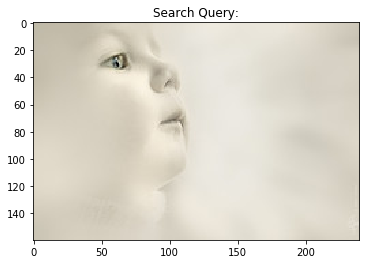

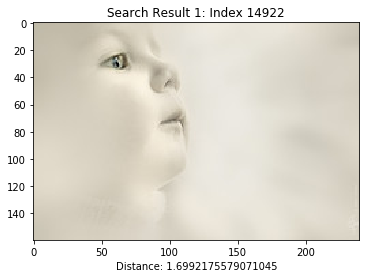

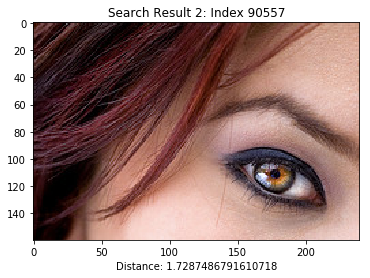

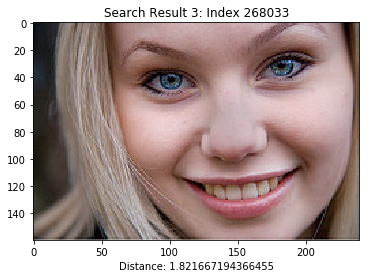

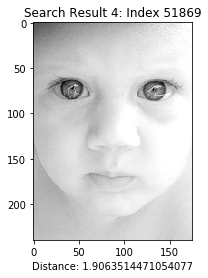

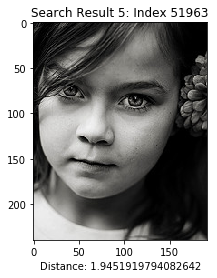

In [51]:
image = image_from_idx[random.randint(0,len(image_from_idx))][0]
image_tensor = image_transform(image)[None,:,:,:]

query_and_display(image, 'image', image_search_engine)

####### TEXT RESULTS #######
Median distance: 1.0878734588623047
Mean distance: 0.8955661654472351
Time elapsed: 0.02434
0 balloon
1 balloons
2 rainbow
3 flag
4 globe
####### IMAGE RESULTS #######
Median distance: 2.0238423347473145
Mean distance: 2.0381808280944824
Time elapsed: 0.00649
Query = balloon


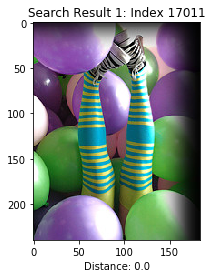

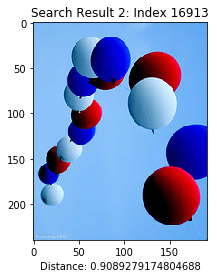

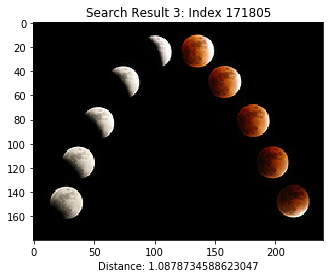

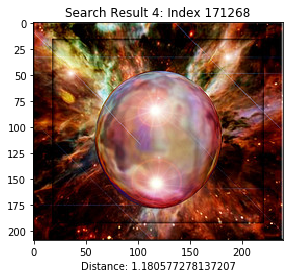

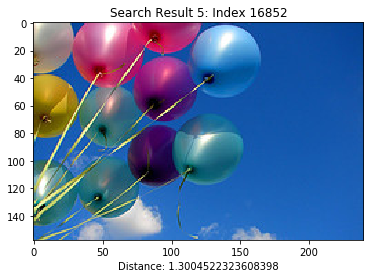

In [52]:
query_and_display('balloon', 'text', image_search_engine)

In [ ]:
embedding = target_to_embedding(image, "image")
distances, idx = text_search_engine.search(embedding, n=5, verbose = True)